In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.dataset import ShanghaiTechDataset
from src.cnn import SimpleCNN


ModuleNotFoundError: No module named 'src'

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import src.cnn
print(dir(src.cnn))


['SimpleCNN', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn']


In [ ]:
img_dir = "../data/ShanghaiTech/part_A/train_data/images"
gt_dir  = "../data/ShanghaiTech/part_A/train_data/ground-truth-h5"

dataset = ShanghaiTechDataset(img_dir, gt_dir, resize=(256, 256))
loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
epochs = 5   # keep small for now

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for img, gt in loader:
        img = img.to(device)
        gt = gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f}")


Epoch 1, Loss: 0.0007
Epoch 2, Loss: 0.0007
Epoch 3, Loss: 0.0007
Epoch 4, Loss: 0.0007
Epoch 5, Loss: 0.0007


In [ ]:
import os
import h5py

gt_dir = "../data/ShanghaiTech/part_A/train_data/ground-truth-h5"

bad_files = []

for fname in os.listdir(gt_dir):
    try:
        with h5py.File(os.path.join(gt_dir, fname), "r"):
            pass
    except Exception:
        bad_files.append(fname)

print("Corrupted files:", len(bad_files))
print(bad_files[:5])


In [ ]:
model.eval()

with torch.no_grad():
    img, gt = next(iter(loader))
    img, gt = img.to(device), gt.to(device)

    pred = model(img)

    print("GT Count:", gt.sum().item())
    print("Pred Count:", pred.sum().item())


GT Count: 624.4569702148438
Pred Count: 370.06341552734375


In [ ]:
test_img_dir = "../data/ShanghaiTech/part_A/test_data/images"
test_gt_dir  = "../data/ShanghaiTech/part_A/test_data/ground-truth-h5"

test_dataset = ShanghaiTechDataset(
    test_img_dir, test_gt_dir, resize=(256, 256)
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
import math

model.eval()

mae = 0.0
mse = 0.0
n = len(test_loader)

with torch.no_grad():
    for img, gt in test_loader:
        img = img.to(device)
        gt = gt.to(device)

        pred = model(img)

        gt_count = gt.sum().item()
        pred_count = pred.sum().item()

        err = abs(pred_count - gt_count)

        mae += err
        mse += err ** 2

mae /= n
rmse = math.sqrt(mse / n)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 226.39
RMSE: 341.72


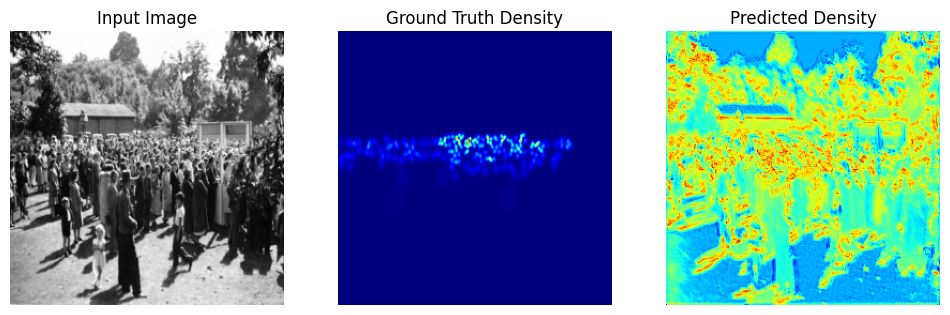

In [ ]:
import matplotlib.pyplot as plt

img, gt = next(iter(test_loader))
img, gt = img.to(device), gt.to(device)

with torch.no_grad():
    pred = model(img)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img[0].permute(1,2,0).cpu())
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt[0,0].cpu(), cmap="jet")
plt.title("Ground Truth Density")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[0,0].cpu(), cmap="jet")
plt.title("Predicted Density")
plt.axis("off")

plt.show()
